In [1]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn import model_selection
from sklearn.datasets import load_diabetes

Для реализованной модели построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

In [2]:
X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [3]:
print(X_train.shape, y_train.shape)

(331, 10) (331,)


In [4]:
def gb_predict(X, trees_list, coef_list, eta):
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

In [5]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [6]:
def bias(y, z):
    return (y - z)

In [7]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [21]:
n_trees = 40
coefs = [1] * n_trees
max_depth = 4
eta = 0.2

In [22]:
trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [23]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

In [24]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 40 деревьев глубиной 4     с шагом 0.2 на тренировочной выборке: 423.2261757233898
Ошибка алгоритма из 40 деревьев глубиной 4     с шагом 0.2 на тестовой выборке: 4048.5364356183813


In [25]:
def error_tree_plot(n_trees, train_err, test_err):
    plt.xlabel('n_trees')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.title('Зависимость ошибки от количества деревьев')
    plt.legend(loc='upper right')

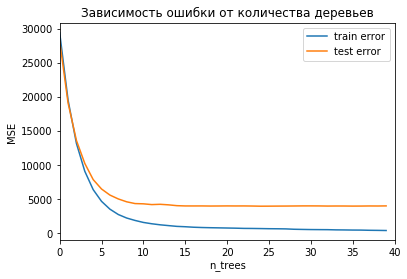

In [26]:
error_tree_plot(n_trees, train_errors, test_errors)

#### На 15шаге качество тестовой выборки перестает улучшаться, при этом переобучение увеличивается.

In [27]:
n_trees = 20
coefs = [1] * n_trees
max_depth = 10
eta = 0.1
train_errors_arr = []
test_errors_arr = []

for i in list(range(1, max_depth)):
    trees, train_errors, test_errors = gb_fit(n_trees, i, X_train, X_test, y_train, y_test, coefs, eta)
    train_prediction = gb_predict(X_train, trees, coefs, eta)
    test_prediction = gb_predict(X_test, trees, coefs, eta)
    train_err = mean_squared_error(y_train, train_prediction)
    test_err = mean_squared_error(y_test, test_prediction)
    train_errors_arr.append(train_err)
    test_errors_arr.append(test_err)

In [33]:
def depth_error_plot(max_depth, train_err, test_err):
    plt.xlabel('tree_depth')
    plt.ylabel('MSE')
    plt.xlim(0, max_depth)
    plt.plot(list(range(1, max_depth)), train_err, label='train error')
    plt.plot(list(range(1, max_depth)), test_err, label='test error')
    plt.title('Зависимость ошибки от максимальной глубины деревьев')
    plt.legend(loc='upper right')
    plt.show()

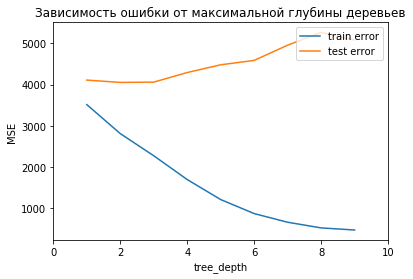

In [34]:
depth_error_plot(max_depth, train_errors_arr, test_errors_arr)

#### Ошибка на тестовой выборке начинает расти после 3х, на тренировочной ошибка падает на всем интервале.

Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

In [35]:
def sgb_fit(subsample_value, n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    trees = []
    
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
                        
        # генерируем случайную подвыборку
        qtt = int(X_train.shape[0] * subsample_value)
        train_ind = np.random.randint(X_train.shape[0], size=qtt)
    
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train[train_ind], y_train[train_ind])
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train[train_ind], bias(y_train[train_ind], target[train_ind]))
            
            train_errors.append(
                mean_squared_error(
                    y_train, gb_predict(X_train, trees, coefs, eta)
                )
            )
            test_errors.append(
                mean_squared_error(
                    y_test, gb_predict(X_test, trees, coefs, eta)
                )
            )

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [61]:
n_trees = 20
coefs = [1] * n_trees
max_depth = 5
eta = 0.2

In [62]:
%%time

trees, train_errors, test_errors = sgb_fit(0.5, n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

Wall time: 12.8 s


In [63]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 20 деревьев глубиной 5     с шагом 0.2 на тренировочной выборке: 16589.262006916535
Ошибка алгоритма из 20 деревьев глубиной 5     с шагом 0.2 на тестовой выборке: 24600.73242295553


In [65]:
#train_errors

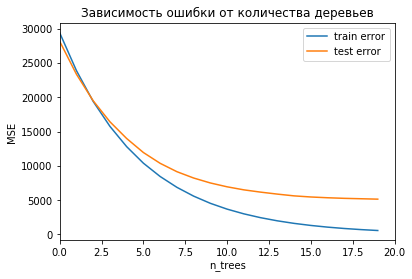

In [66]:
error_tree_plot(20, train_errors, test_errors)